# PURCHASE  ANALYTICS

In [235]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

In [236]:
#load data
df_purchase = pd.read_csv('MAIN_ORIGINAL_purchase_data.csv')
pd.options.display.max_columns 
df_purchase.head(3)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0


In [237]:

scaler = pickle.load(open('scaler.pickle', 'rb'))  # Import the standard scaler 'Scale' trained in Customer_segmentation part
pca = pickle.load(open('pca.pickle', 'rb'))  # Import PCA trained in Customer_segmentation part
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))  # Import K-Means trained in Customer_segmentation part


features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)  #  Standardization transformation only
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)  #Apply PCA transformation to get Principle Components (new variables)
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)  # KMeans on PCA data (segmentation) prediction of clusters


df_purchase_predictors = df_purchase.copy()
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca  # Add segment labels 

segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors 
df_pa.head()  #final dataset of purchase analytics df_pa
# 0:standard , 1:career focused, 2:fewer opportunities, 3: well-off

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,2,0,0,1,0


# 1. Purchase Probability Model - Price Elasticity of Purchase Probability

In [238]:
Y=df_pa['Incidence']
X=pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5
model_purchase=LogisticRegression(solver='sag')
model_purchase.fit(X,Y)
model_purchase.coef_   # gives m of Y=mX+c of logistic reg, it is -ve means as price inc buying dec

array([[-2.35424717]])

## Price Elasticity of Purchase Probability

In [239]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [240]:
price_range=np.arange(0.5,3.5,0.01)
df_price_range=pd.DataFrame(price_range)
Y_pr=model_purchase.predict_proba(df_price_range)
purchase_pr=Y_pr[:,1]  # to select prob of purchase for each price point 


In [241]:
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)
df_price_elasticities = pd.DataFrame(price_range)
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
#pd.options.display.max_rows = None
df_price_elasticities.head()


,Price_Point,Mean_PE
0,0.50,-0.096752
1,0.51,-0.100840
2,0.52,-0.105057
3,0.53,-0.109404
4,0.54,-0.113886


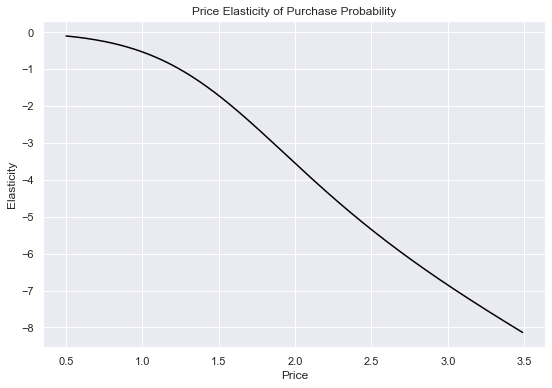

In [242]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'black')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

In [243]:
# 0:standard , 1:career focused, 2:fewer opportunities, 3: well-off
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]
Y = df_pa_segment_1['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)
df_price_elasticities['PE_Segment_1'] = pe_segment_1


df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]
Y = df_pa_segment_2['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5
model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)
df_price_elasticities['PE_Segment_2'] = pe_segment2


df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
Y = df_pa_segment_0['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)
model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities['PE_Segment_0'] = pe_segment0



df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
Y = df_pa_segment_3['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)
model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3

df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2,PE_Segment_0,PE_Segment_3
0,0.50,-0.096752,-0.119139,-0.030979,-0.211237,-0.010598
1,0.51,-0.100840,-0.123324,-0.032750,-0.217810,-0.011203
2,0.52,-0.105057,-0.127602,-0.034607,-0.224491,-0.011839
3,0.53,-0.109404,-0.131974,-0.036555,-0.231281,-0.012505
4,0.54,-0.113886,-0.136443,-0.038599,-0.238179,-0.013204


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

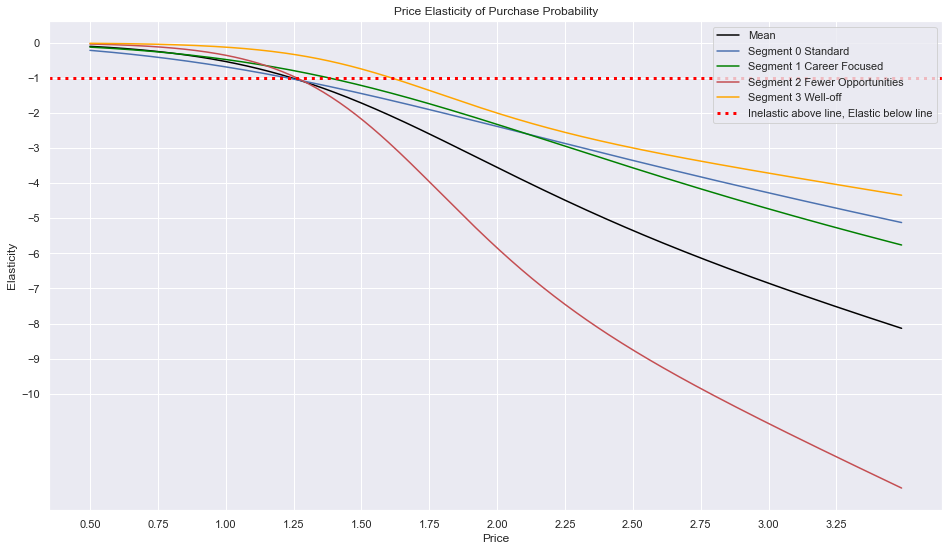

In [244]:
plt.figure(figsize = (16, 9))
plt.plot(price_range, pe, color = 'black', label='Mean')
plt.plot(price_range, pe_segment0, color = 'b', label='Segment 0 Standard')
plt.plot(price_range, pe_segment_1, color = 'green',label='Segment 1 Career Focused')
plt.plot(price_range, pe_segment2, color = 'r',label='Segment 2 Fewer Opportunities')
plt.plot(price_range, pe_segment3, color = 'orange',label='Segment 3 Well-off')
plt.axhline(y=-1, color='red', linestyle='dotted', linewidth=3, label= 'Inelastic above line, Elastic below line')
plt.yticks(range(-10,1))
plt.xticks(np.arange(0.5, 3.5, 0.25))
plt.legend(loc = 'upper right')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

# 0:Standard , 1:Career-Focused, 2:Fewer Opportunities, 3: Well-off

# 2. Brand Choice Model - Price Elasticity of Brand 

In [245]:
brand_choice = df_pa[df_pa['Incidence'] == 1]
Y = brand_choice['Brand']
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)


LogisticRegression(multi_class='multinomial', solver='sag')

### Brand 5 analysis

In [246]:
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5.head()


,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

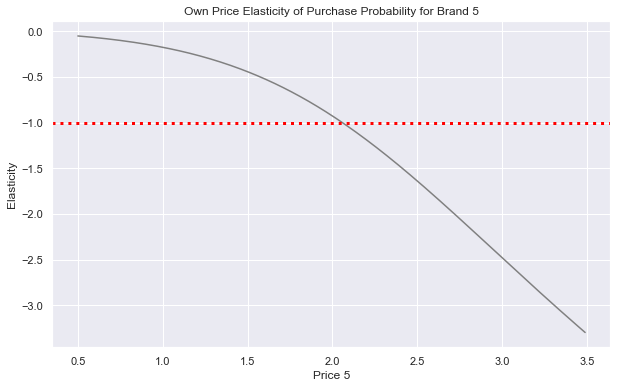

In [247]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)
pr_own_brand_5 = predict_brand_5[: ][:, 4]
beta5 = bc_coef.iloc[4, 4]
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)
#df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
#df_price_elasticities.head(3)
plt.figure(figsize = (10, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.axhline(y=-1, color='red', linestyle='dotted', linewidth=3, label= 'Inelastic above line, Elastic below line')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')